In [29]:
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gensim
from gensim.models import Word2Vec
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from src.dataset import read_lang_dataset, tokenize_dataset, get_vocab_mapping, gateways

sns.set_theme()
sns.set(rc={'figure.figsize': (12, 8)})

In [30]:
csharp_df = read_lang_dataset("data/codes_go.db")
csharp_df

,language,code
0,Go,"package handler\n\nimport (\n\t""log""\n\t""net/h..."
1,Go,"package main\n\nimport (\n\t""encoding/json""\n\..."
2,Go,"package main\n\nimport (\n\t""context""\n\t""log""..."
3,Go,"package model\n\nimport (\n\t""database/sql/dri..."
4,Go,"package db\n\nimport (\n\t""context""\n\n\t""gith..."
...,...,...
2198,Go,"package postgresql\n\nimport (\n\t""database/sq..."
2199,Go,"package web\n\nimport (\n\t""database/sql""\n\t""..."
2200,Go,"// Copyright (C) 2019-2021, Ava Labs, Inc. All..."
2201,Go,"package database\n\nimport (\n\t""database/sql""..."


In [31]:
tokenized_sample = tokenize_dataset(csharp_df)
tokenized_sample

  0%|          | 10/2203 [00:10<39:33,  1.08s/it] 

In [26]:
model = Word2Vec(tokenized_sample.code, vector_size=100, window=10, min_count=5, workers=7)

# Visualize

In [27]:
def word_cloud(words):
    words = list(set(words))
    words = [word for word in words if word in model.wv]
    vecs = [model.wv[word] for word in words]
    vecs = np.asarray(vecs)
    # visulize 2D with dimensionality reductino
    pca = PCA(2)
    vecs = pca.fit_transform(vecs)
    ax = sns.scatterplot(x=vecs[:,0], y=vecs[:,1])
    for i, word in enumerate(words):
        ax.text(vecs[i,0] + 0.01, vecs[i,1], word,
            verticalalignment='center', horizontalalignment='left', fontsize=8)
    return ax

<AxesSubplot: >

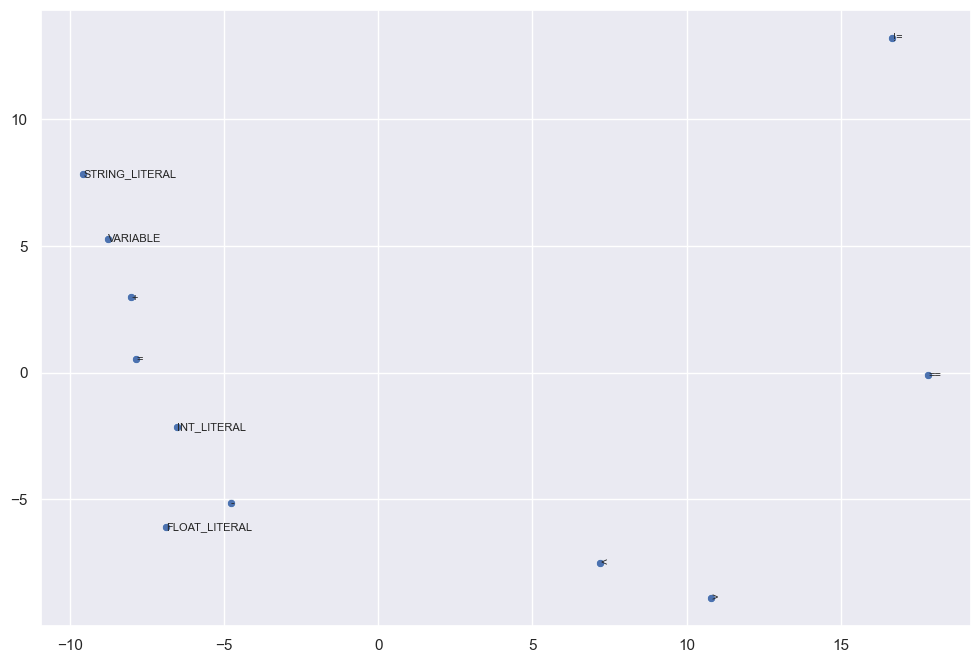

In [28]:
word_cloud(["INT_LITERAL", "FLOAT_LITERAL", "VARIABLE", "STRING_LITERAL", "==", "!=", "<", ">", "+", "=", "-"])